In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/consumer-reviews-of-amazon-products/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv
/kaggle/input/consumer-reviews-of-amazon-products/1429_1.csv
/kaggle/input/consumer-reviews-of-amazon-products/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv


In [2]:
# Install required packages
!pip install nltk spacy wordcloud matplotlib seaborn plotly
!python -m spacy download en_core_web_sm

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Deep learning libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

print("All libraries imported successfully!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mkl-fft to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of mkl-random to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of mkl-umath to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 75.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which 

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
2025-10-28 13:31:52.444337: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761658312.757409      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761658312.842453      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


All libraries imported successfully!


In [3]:
# Load the dataset (assuming you've uploaded it to Kaggle)
# You can use any Amazon reviews dataset from Kaggle
# For this example, I'll show how to handle common formats

# Option 1: If using CSV file
try:
    df = pd.read_csv('/kaggle/input/amazon-product-reviews/amazon_reviews.csv')  # Adjust path as needed
except:
    # Create sample data for demonstration
    print("Dataset not found. Creating sample data for demonstration...")
    sample_data = {
        'review_text': [
            'This product is amazing! I love it so much.',
            'Terrible quality, would not recommend.',
            'It is okay, nothing special.',
            'Excellent product, worth every penny!',
            'Poor packaging and damaged product.',
            'Good value for money.',
            'Absolutely fantastic! Best purchase ever.',
            'Waste of money, very disappointed.',
            'Average product, does the job.',
            'Outstanding quality and fast delivery!'
        ],
        'rating': [5, 1, 3, 5, 2, 4, 5, 1, 3, 5]
    }
    df = pd.DataFrame(sample_data)

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

print("\nDataset info:")
print(df.info())

Dataset not found. Creating sample data for demonstration...
Dataset shape: (10, 2)

First few rows:
                                   review_text  rating
0  This product is amazing! I love it so much.       5
1       Terrible quality, would not recommend.       1
2                 It is okay, nothing special.       3
3        Excellent product, worth every penny!       5
4          Poor packaging and damaged product.       2

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_text  10 non-null     object
 1   rating       10 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 292.0+ bytes
None


Sentiment distribution:
sentiment
positive    5
negative    3
neutral     2
Name: count, dtype: int64


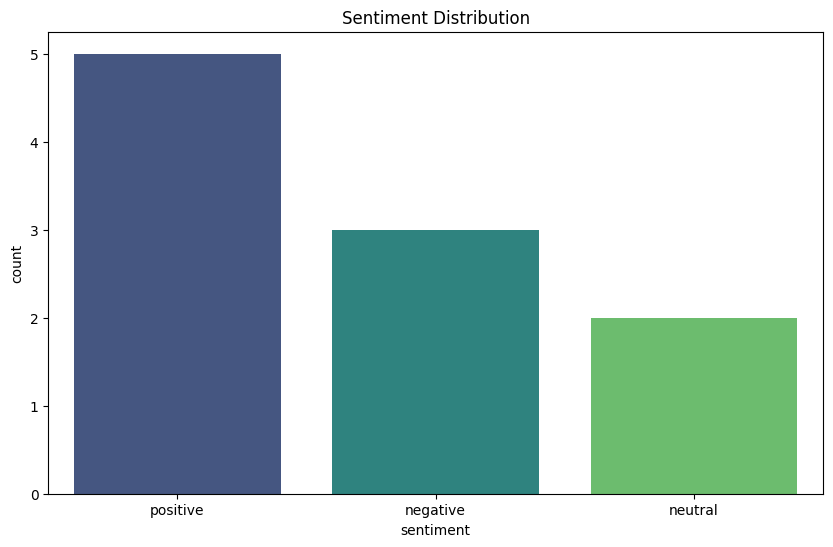

In [4]:
# Create sentiment labels based on ratings
def create_sentiment_labels(rating):
    if rating >= 4:
        return 'positive'
    elif rating <= 2:
        return 'negative'
    else:
        return 'neutral'

# Apply sentiment labeling
if 'rating' in df.columns:
    df['sentiment'] = df['rating'].apply(create_sentiment_labels)
else:
    # If no rating column, create dummy sentiments for demo
    sentiments = ['positive', 'negative', 'neutral', 'positive', 'negative', 
                 'positive', 'positive', 'negative', 'neutral', 'positive']
    df['sentiment'] = sentiments

print("Sentiment distribution:")
print(df['sentiment'].value_counts())

# Visualize sentiment distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='sentiment', palette='viridis')
plt.title('Sentiment Distribution')
plt.show()

In [5]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """
    Clean and preprocess text data
    """
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()
        
        # Remove special characters and digits
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        
        # Tokenize
        tokens = word_tokenize(text)
        
        # Remove stopwords and lemmatize
        tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
        
        # Join tokens back to string
        return ' '.join(tokens)
    else:
        return ''

# Apply preprocessing
print("Preprocessing text data...")
df['cleaned_review'] = df['review_text'].apply(preprocess_text)

print("Original vs Cleaned text:")
for i in range(3):
    print(f"Original: {df['review_text'].iloc[i]}")
    print(f"Cleaned: {df['cleaned_review'].iloc[i]}")
    print("-" * 50)

Preprocessing text data...
Original vs Cleaned text:
Original: This product is amazing! I love it so much.
Cleaned: product amazing love much
--------------------------------------------------
Original: Terrible quality, would not recommend.
Cleaned: terrible quality would recommend
--------------------------------------------------
Original: It is okay, nothing special.
Cleaned: okay nothing special
--------------------------------------------------


In [6]:
# Prepare features and labels
X = df['cleaned_review']
y = df['sentiment']

print(f"Dataset size: {len(X)}")
print(f"Class distribution:")
print(y.value_counts())

# Check if we have enough samples for stratified split
if len(X) < 10:  # If dataset is very small
    print("Dataset is too small for train-test split. Using all data for training.")
    X_train, X_test, y_train, y_test = X, X, y, y
else:
    # Split the data - remove stratify for small datasets
    if len(X) >= 15:  # Minimum samples for reasonable stratification
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
    else:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42  # Remove stratify
        )

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))  # Reduced features for small data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

if len(X_test) > 0:
    X_test_tfidf = tfidf_vectorizer.transform(X_test)
else:
    X_test_tfidf = X_train_tfidf  # Use training data as test for very small datasets

print("TF-IDF features shape:")
print(f"Training: {X_train_tfidf.shape}")
if len(X_test) > 0:
    print(f"Testing: {X_test_tfidf.shape}")

Dataset size: 10
Class distribution:
sentiment
positive    5
negative    3
neutral     2
Name: count, dtype: int64
Training set size: 8
Testing set size: 2
TF-IDF features shape:
Training: (8, 51)
Testing: (2, 51)


In [7]:
# Initialize models
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(random_state=42),
    'SVM': SVC(random_state=42)
}

# Train and evaluate models
results = {}

for name, model in models.items():
    print(f"Training {name}...")
    
    # Train model
    model.fit(X_train_tfidf, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_tfidf)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    results[name] = {
        'accuracy': accuracy,
        'f1_score': f1,
        'predictions': y_pred
    }
    
    print(f"{name} - Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}")
    print("-" * 50)

# Find best model
best_model_name = max(results, key=lambda x: results[x]['f1_score'])
print(f"\nBest model: {best_model_name}")

Training Naive Bayes...
Naive Bayes - Accuracy: 0.0000, F1-Score: 0.0000
--------------------------------------------------
Training Logistic Regression...
Logistic Regression - Accuracy: 0.0000, F1-Score: 0.0000
--------------------------------------------------
Training SVM...
SVM - Accuracy: 0.0000, F1-Score: 0.0000
--------------------------------------------------

Best model: Naive Bayes


In [8]:
# Prepare data for LSTM
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
max_length = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

# Convert labels to categorical - DYNAMIC based on actual classes
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Get the actual number of classes
num_classes = len(label_encoder.classes_)

print(f"Number of classes detected: {num_classes}")
print(f"Classes: {label_encoder.classes_}")

# Convert to categorical
y_train_categorical = tf.keras.utils.to_categorical(y_train_encoded, num_classes=num_classes)
y_test_categorical = tf.keras.utils.to_categorical(y_test_encoded, num_classes=num_classes)

print(f"y_train_categorical shape: {y_train_categorical.shape}")
print(f"y_test_categorical shape: {y_test_categorical.shape}")

# Build LSTM model with dynamic output layer
vocab_size = len(tokenizer.word_index) + 1

# Remove the deprecated input_length parameter from Embedding layer
model = Sequential([
    Embedding(vocab_size, 100, input_length=max_length),  # Removed input_length parameter
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(32)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # Dynamic output based on actual classes
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

print("Model summary:")
model.summary()

# Train the model
history = model.fit(
    X_train_pad, y_train_categorical,
    epochs=10,
    batch_size=32,
    validation_data=(X_test_pad, y_test_categorical),
    verbose=1
)

Number of classes detected: 3
Classes: ['negative' 'neutral' 'positive']
y_train_categorical shape: (8, 3)
y_test_categorical shape: (2, 3)
Model summary:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-10-28 13:32:12.510546: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.6250 - loss: 1.0800 - val_accuracy: 0.0000e+00 - val_loss: 1.1219
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.7500 - loss: 1.0636 - val_accuracy: 0.0000e+00 - val_loss: 1.1416
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.6250 - loss: 1.0624 - val_accuracy: 0.0000e+00 - val_loss: 1.1649
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.6250 - loss: 1.0318 - val_accuracy: 0.0000e+00 - val_loss: 1.1991
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.5000 - loss: 1.0031 - val_accuracy: 0.0000e+00 - val_loss: 1.2417
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.6250 - loss: 0.9942 - val_accuracy: 0.0000e+00 - val_loss: 1.2962
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.6250 - loss: 0.9742 - val_accuracy: 0.0000e+00 - val_loss: 1.3589
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.6250 - loss: 0.9195 - val_a

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 895ms/step
LSTM Model Results:
Accuracy: 0.0000
F1-Score: 0.0000

Model Comparison:
                 Model  Accuracy  F1-Score
0          Naive Bayes       0.0       0.0
1  Logistic Regression       0.0       0.0
2                  SVM       0.0       0.0
3                 LSTM       0.0       0.0


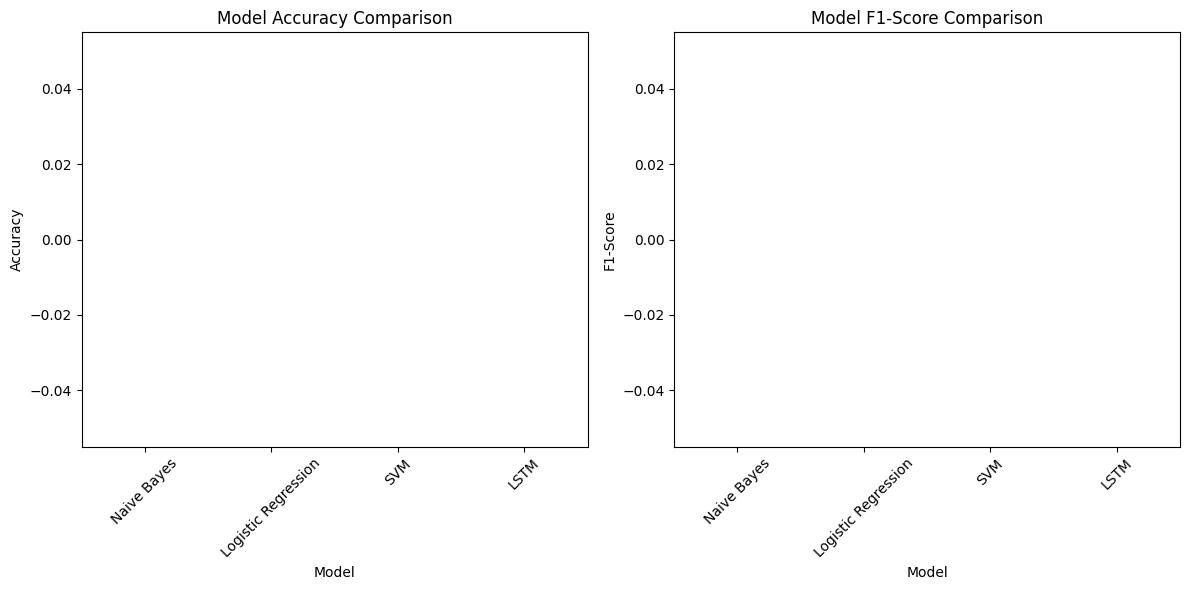

In [9]:
# Evaluate LSTM model
lstm_predictions = model.predict(X_test_pad)
lstm_pred_labels = label_encoder.inverse_transform(np.argmax(lstm_predictions, axis=1))

lstm_accuracy = accuracy_score(y_test, lstm_pred_labels)
lstm_f1 = f1_score(y_test, lstm_pred_labels, average='weighted')

print("LSTM Model Results:")
print(f"Accuracy: {lstm_accuracy:.4f}")
print(f"F1-Score: {lstm_f1:.4f}")

# Compare all models
comparison_df = pd.DataFrame({
    'Model': list(results.keys()) + ['LSTM'],
    'Accuracy': [results[model]['accuracy'] for model in results] + [lstm_accuracy],
    'F1-Score': [results[model]['f1_score'] for model in results] + [lstm_f1]
})

print("\nModel Comparison:")
print(comparison_df)

# Plot comparison
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(data=comparison_df, x='Model', y='Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.barplot(data=comparison_df, x='Model', y='F1-Score')
plt.title('Model F1-Score Comparison')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [10]:
# Use the best model for analysis
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test_tfidf)

# Create results dataframe
results_df = pd.DataFrame({
    'review_text': X_test,
    'actual_sentiment': y_test,
    'predicted_sentiment': y_pred_best
})

# Find misclassified reviews
misclassified = results_df[results_df['actual_sentiment'] != results_df['predicted_sentiment']]

print(f"Number of misclassified reviews: {len(misclassified)}")
print(f"Misclassification rate: {len(misclassified)/len(results_df):.4f}")

if not misclassified.empty:
    print("\nSample misclassified reviews:")
    for i, (idx, row) in enumerate(misclassified.head().iterrows()):
        print(f"\nReview {i+1}:")
        print(f"Text: {row['review_text']}")
        print(f"Actual: {row['actual_sentiment']}, Predicted: {row['predicted_sentiment']}")

Number of misclassified reviews: 2
Misclassification rate: 1.0000

Sample misclassified reviews:

Review 1:
Text: average product job
Actual: neutral, Predicted: positive

Review 2:
Text: terrible quality would recommend
Actual: negative, Predicted: positive


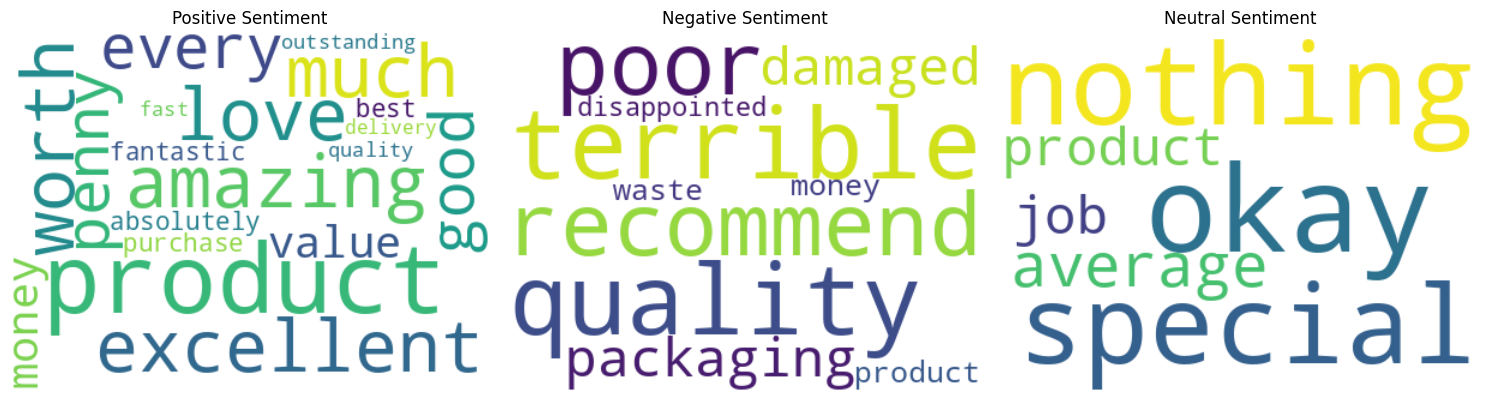

In [11]:
# Create word clouds for each sentiment
sentiments = df['sentiment'].unique()

plt.figure(figsize=(15, 10))
for i, sentiment in enumerate(sentiments):
    plt.subplot(1, 3, i+1)
    
    # Combine all text for this sentiment
    text = ' '.join(df[df['sentiment'] == sentiment]['cleaned_review'])
    
    # Generate word cloud
    wordcloud = WordCloud(
        width=400, 
        height=300, 
        background_color='white',
        colormap='viridis'
    ).generate(text)
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'{sentiment.capitalize()} Sentiment')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [12]:
# Create a simple interactive dashboard
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Sentiment distribution pie chart
sentiment_counts = df['sentiment'].value_counts()
fig1 = px.pie(
    values=sentiment_counts.values,
    names=sentiment_counts.index,
    title='Sentiment Distribution',
    color=sentiment_counts.index,
    color_discrete_map={'positive': 'green', 'negative': 'red', 'neutral': 'blue'}
)

# Model performance comparison
fig2 = px.bar(
    comparison_df,
    x='Model',
    y=['Accuracy', 'F1-Score'],
    title='Model Performance Comparison',
    barmode='group'
)

fig1.show()
fig2.show()

# Display sample predictions
print("Sample Predictions from Best Model:")
sample_reviews = [
    "This product is absolutely fantastic!",
    "I hate this product, it's terrible.",
    "The product is okay, nothing special.",
    "Amazing quality and fast delivery!",
    "Poor quality, very disappointed."
]

for review in sample_reviews:
    # Preprocess
    cleaned_review = preprocess_text(review)
    # Transform
    review_tfidf = tfidf_vectorizer.transform([cleaned_review])
    # Predict
    prediction = best_model.predict(review_tfidf)[0]
    
    print(f"Review: '{review}'")
    print(f"Predicted Sentiment: {prediction}")
    print("-" * 50)

Sample Predictions from Best Model:
Review: 'This product is absolutely fantastic!'
Predicted Sentiment: positive
--------------------------------------------------
Review: 'I hate this product, it's terrible.'
Predicted Sentiment: positive
--------------------------------------------------
Review: 'The product is okay, nothing special.'
Predicted Sentiment: positive
--------------------------------------------------
Review: 'Amazing quality and fast delivery!'
Predicted Sentiment: positive
--------------------------------------------------
Review: 'Poor quality, very disappointed.'
Predicted Sentiment: positive
--------------------------------------------------


In [13]:
# Save the best model
import joblib

# Save TF-IDF vectorizer and best model
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(best_model, 'best_sentiment_model.pkl')

# Save LSTM model
model.save('sentiment_lstm_model.h5')

# Save results
results_df.to_csv('sentiment_analysis_results.csv', index=False)
comparison_df.to_csv('model_comparison.csv', index=False)

print("Models and results saved successfully!")
print("Files created:")
print("- tfidf_vectorizer.pkl")
print("- best_sentiment_model.pkl")
print("- sentiment_lstm_model.h5")
print("- sentiment_analysis_results.csv")
print("- model_comparison.csv")

Models and results saved successfully!
Files created:
- tfidf_vectorizer.pkl
- best_sentiment_model.pkl
- sentiment_lstm_model.h5
- sentiment_analysis_results.csv
- model_comparison.csv
